<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Project : Visual tracking of video objects - GoTurn </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
R. Fablet <span style="color:blue">ronan.fablet@imt-atlantique.fr</span> - 
A. Colin <span style="color:blue">acolin@groupcls.com</span>
    
Students:
G. Rodrigues dos Reis <span style="color:blue">gustavo.rodrigues-dos-reis@imt-atlantique.net</span> -
G. I. Quintana <span style="color:blue">gonzalo-inaki.quintana@imt-atlantique.net</span> -
M. Riera i Marín <span style="color:blue">meritxell.riera-i-marin@imt-atlantique.net</span> -
M. Pastorino <span style="color:blue">martina.pastorino@imt-atlantique.net</span>
<CENTER>
</CENTER>
</div> 

## Purpose of the project

Implement the methodology described in the article David Held, et al. - "Learning to Track at 100 FPS with Deep Regression Networks" -  and apply it in the context of **visual tracking of video objects** within image sequences.

In [1]:
import numpy as np
import cv2
from skimage import io
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

## Data

In [2]:
name_list = ['bag', 'bear', 'book','camel','cows','fish', 'octopus', 'rhino', 'swan']
im_end_list = [196, 26, 51, 90, 104, 26, 26, 90, 50]
choice =  0 # A number between 0 and 8 corresponding to the name of the sequence to evaluate

name = name_list[choice] # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, im_end_list[choice]              # reference image (1) and last image (varies depending on the sequence)
output_folder = './our_results/'+name+'/' # result folder
output_baseline = './outputs_baseline/'+name+'/'

## Assessment

**DICE_assessment()** evaluates the overlap between the two masks while **db_eval_boundary()** quantifies the quality of the estimated contours. Each function returns a score between 0 (poor quality) and 100 (perfect quality).

**centroid_assessment()** comptes the Euclidean distance between groundtruth and estimated centroids.

In [3]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [4]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called reference image. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an openCV implementation of **Farnebäck's optical flow estimator** (G. Farnebäck, “Two-frame motion estimation based on polynomial expansion,” Image Analysis, pp. 363–370, 2003) is used.


In [5]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the **propagate_mask()** function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [6]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [7]:
img_begin = io.imread('./baseline_sequence_train/'+name+'/%0*d.bmp'%(3,im_begin))
mask_begin = io.imread('./baseline_sequence_train/'+name+'/%0*d.png'%(3,im_begin))

dices_baseline, centroid_dist_baseline= [], []
for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./baseline_sequence_train/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('./baseline_sequence_train/'+name+'/%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(output_baseline+'prop-%0*d.png'%(3,im), propagation)
    dices_baseline.append(DICE_assessment(mask_current, propagation))
    centroid_dist_baseline.append(centroid_assessment(mask_current, propagation))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


## Evaluation on Pygoturn method

In [10]:
mask_begin = io.imread('./our_results/'+name+'/%d_GT.bmp'%(im_begin))
mask_predicted = io.imread('./our_results/'+name+'/%d_Pre.bmp'%(im_begin))


dices, centroid_dist= [], []
dices_delta, centroid_dist_delta = [], []
dices_fb, centroid_dist_fb = [], []
for im in range(im_begin+1,im_end+1):
    mask_current = io.imread('./our_results/'+name+'/%d_GT.bmp'%(im))
    mask_predicted = io.imread('./our_results/'+name+'/%d_Pre.bmp'%(im))
    
    mask_current_delta = io.imread('./our_results/'+name+'_delta'+'/%d_GT.bmp'%(im))
    mask_predicted_delta = io.imread('./our_results/'+name+'_delta'+'/%d_Pre.bmp'%(im))
    
    mask_current_fb = io.imread('./our_results/'+name+'_fb'+'/%d_GT.bmp'%(im))
    mask_predicted_fb = io.imread('./our_results/'+name+'_fb'+'/%d_Pre.bmp'%(im))
    
    dices.append(DICE_assessment(mask_current, mask_predicted))
    centroid_dist.append(centroid_assessment(mask_current, mask_predicted))
    
    dices_delta.append(DICE_assessment(mask_current_delta, mask_predicted_delta))
    centroid_dist_delta.append(centroid_assessment(mask_current_delta, mask_predicted_delta))
    
    dices_fb.append(DICE_assessment(mask_current_fb, mask_predicted_fb))
    centroid_dist_fb.append(centroid_assessment(mask_current_fb, mask_predicted_fb))

In GoTurn  for fast-moving objects, the size of the search region could be increased, at a cost of increasing the complexity of the network and this would imply training the network from scratch and it could not be done, however we exploit the use of different instances of GoTurn to evaluate different kind of performances that could be obtained with the already trained network (Available at: (https://drive.google.com/file/d/1szpx3J-hfSrBEi_bze3d0PjSfQwNij7X/view?usp=sharing). The original implementation in Keras is available at : https://github.com/amoudgl/pygoturn

In this analysis we have three different uses of GoTurn:
- The original algorithm (presented in red in the plots).

- the delta modification: taking the mean of all corners within two different moments of time, the current frame and a past frame t- delta where in this case delta = 5.

- the fb modification (forward-backward): using two instances of goturn, one will perform the propagation of the mask since the first picture (the reference) and the other will propagate the mask using the last frame as a reference. Even if it is not the case having this information the objective was to see how the initialization of a search area could lead to better or worse results. In the case of some sequences as rhino we could see a little improvement of performance when the object changes suddenly its format. The result is always the mean in an instant t for the output of the two instances of the network.

## Result visualization


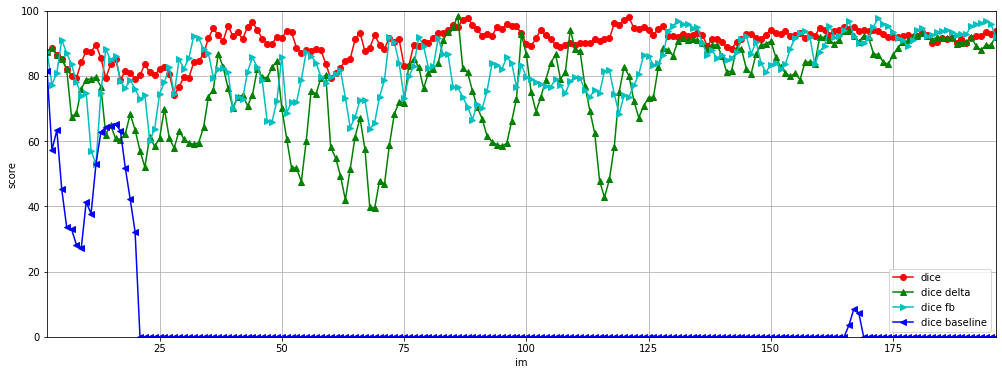

In [12]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,dices_delta,marker='^',color='g')
plt.plot(x,dices_fb,marker='>',color='c')
plt.plot(x,dices_baseline,marker='<',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'dice delta', 'dice fb', 'dice baseline'])
plt.savefig(output_folder+'eval.png')
plt.show()

We can see that depending of the sequence goturn could perform the tracking in a significant better way rather than the baseline method.

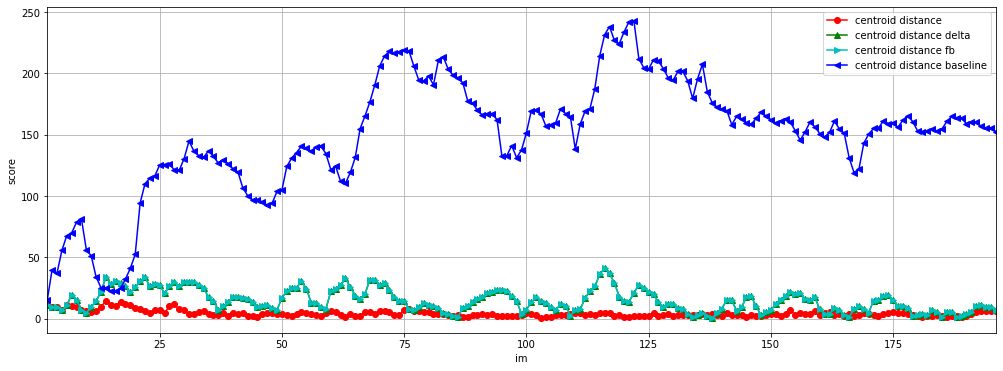

In [13]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.plot(x,centroid_dist_delta,marker='^',color='g')
plt.plot(x,centroid_dist_delta,marker='>',color='c')
plt.plot(x,centroid_dist_baseline,marker='<',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance','centroid distance delta','centroid distance fb', 'centroid distance baseline'])
plt.savefig(output_folder+'eval-centroid.png')
plt.show()

We could also see good performance of GoTurn within the centroid distance method metric, even though generally adding extra information from the past could not be proved as a worthy modification.

<Figure size 432x288 with 0 Axes>

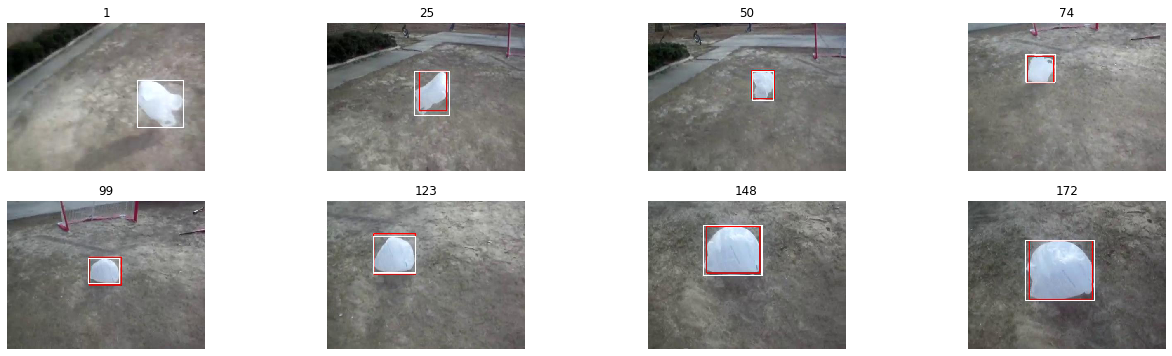

In [14]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(io.imread('./our_results/'+name+'/%d.jpg'%(im+1)))
    plt.title('%i' %(im+1))
plt.show()

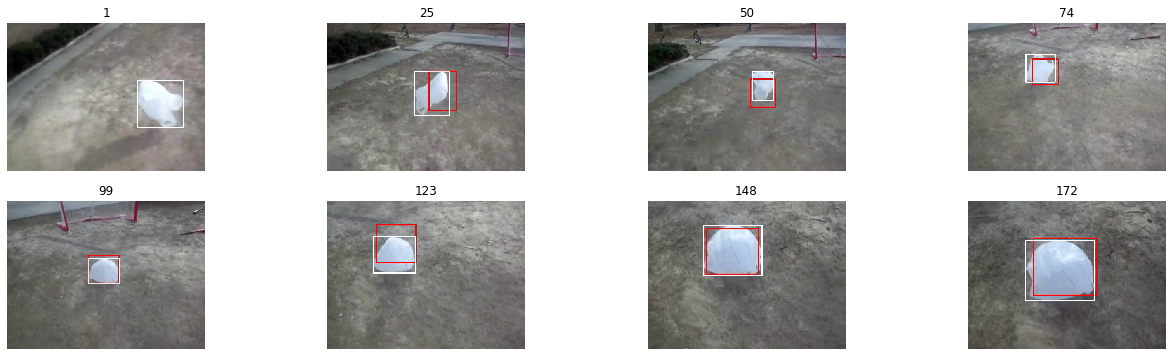

In [15]:
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(io.imread('./our_results/'+name+'_delta'+'/%d.jpg'%(im+1)))
    plt.title('%i' %(im+1))
plt.show()